# Experimenting with different ansatzes on breast cancer dataset

In [74]:
from matplotlib import pyplot as plt
import numpy as np
from qiskit import Aer, execute
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import MissingOptionalLibraryError
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd

## Dataset Preview

In [2]:
data = datasets.load_breast_cancer()
target = data.target
data = data.data

training_dataset_size = 10
testing_dataset_size = 10
class_labels = ["A", "B"]

pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## 2 dimensions/qubits

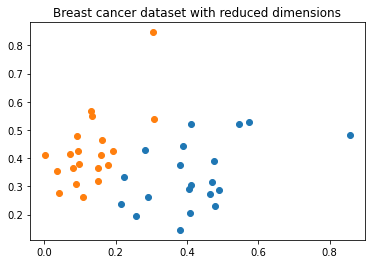

In [75]:
dim = 2
training_dataset_size = 20
testing_dataset_size = 10

class_labels = ["A", "B"]
sample_train, sample_test, label_train, label_test = train_test_split(data, target, random_state=10)

# Standardizing the dataset -- gaussian with unit variance and 0 mean
std = StandardScaler()
std.fit(sample_train)
sample_train = std.transform(sample_train)
sample_test = std.transform(sample_test)

# Using PCA to reduce no. of dimensions to 2 to match number of qubits
pca = PCA(dim)
pca.fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Scaling data to range from -1 to 1
minmax = MinMaxScaler()
minmax = minmax.fit(sample_train)
sample_train = minmax.transform(sample_train)
sample_test = minmax.transform(sample_test)

# Setting dataset size to number of training_dataset_size
training_input = {key: (sample_train[label_train == k, :])[:training_dataset_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:testing_dataset_size] for k, key in enumerate(class_labels)}

# Plotting data
for k in range(0, 2):
    plt.scatter(sample_train[label_train == k, 0][:training_dataset_size],
                sample_train[label_train == k, 1][:training_dataset_size])

plt.title("Breast cancer dataset with reduced dimensions")
plt.show()

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

### ZZFeatureMap ansatz

In [84]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


In [85]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


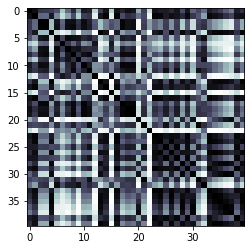

In [86]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [87]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print(" RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1]
 RESULTS Testing success ratio:  0.95


### ZFeatureMap ansatz

In [134]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_3: ┤ H ├┤ U1(2.0*x[3]) ├┤ H ├┤ U1(2.0*x[3]) ├
     └───┘└──────────────┘└───┘└──────────────┘


In [135]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


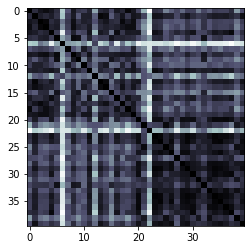

In [136]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [137]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
RESULTS Testing success ratio:  0.9


### PauliFeatureMap ansatz

In [104]:
backend = Aer.get_backend('qasm_simulator')
feature_map = PauliFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


In [105]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


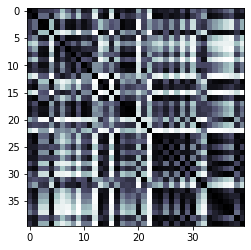

In [106]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [107]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1]
RESULTS Testing success ratio:  0.8


## 3 dimensions/qubits 

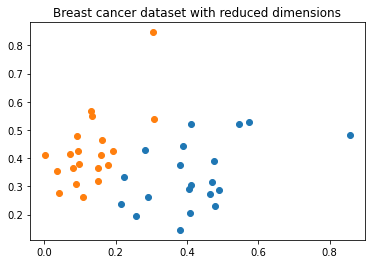

In [108]:
dim = 3
training_dataset_size = 20
testing_dataset_size = 10

class_labels = ["A", "B"]
sample_train, sample_test, label_train, label_test = train_test_split(data, target, random_state=10)

# Standardizing the dataset -- gaussian with unit variance and 0 mean
std = StandardScaler()
std.fit(sample_train)
sample_train = std.transform(sample_train)
sample_test = std.transform(sample_test)

# Using PCA to reduce no. of dimensions to 2 to match number of qubits
pca = PCA(dim)
pca.fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Scaling data to range from -1 to 1
minmax = MinMaxScaler()
minmax = minmax.fit(sample_train)
sample_train = minmax.transform(sample_train)
sample_test = minmax.transform(sample_test)

# Setting dataset size to number of training_dataset_size
training_input = {key: (sample_train[label_train == k, :])[:training_dataset_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:testing_dataset_size] for k, key in enumerate(class_labels)}

# Plotting data
for k in range(0, 2):
    plt.scatter(sample_train[label_train == k, 0][:training_dataset_size],
                sample_train[label_train == k, 1][:training_dataset_size])

plt.title("Breast cancer dataset with reduced dimensions")
plt.show()

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

### ZZFeatureMap ansatz

In [109]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     └───┘└──────────────┘                                           └───┘»
«                                           ┌───┐»
«q_0: ───────────────────────────────────■──┤ H ├»
«                                        │  └───┘»
«q_1: ───────────────────────────────────┼────■──»
«     ┌───────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_2: ┤ U1(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├»
«     └───────────────────────────────┘└───┘└───┘»
«              ┌──────────────┐                                       »
«q_0: ─────────┤ U1(2.0*x[0]) ├────────

In [110]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


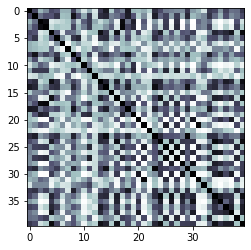

In [111]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [112]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print(" RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1]
 RESULTS Testing success ratio:  0.9


### ZFeatureMap ansatz

In [113]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├
     └───┘└──────────────┘└───┘└──────────────┘


In [114]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


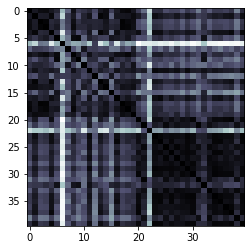

In [115]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [116]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1]
RESULTS Testing success ratio:  0.9


### PauliFeatureMap ansatz

In [117]:
backend = Aer.get_backend('qasm_simulator')
feature_map = PauliFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     └───┘└──────────────┘                                           └───┘»
«                                           ┌───┐»
«q_0: ───────────────────────────────────■──┤ H ├»
«                                        │  └───┘»
«q_1: ───────────────────────────────────┼────■──»
«     ┌───────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_2: ┤ U1(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├»
«     └───────────────────────────────┘└───┘└───┘»
«              ┌──────────────┐                                       »
«q_0: ─────────┤ U1(2.0*x[0]) ├────────

In [118]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


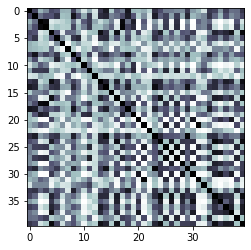

In [119]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [120]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1]
RESULTS Testing success ratio:  0.9


## 4 dimensions/qubits 

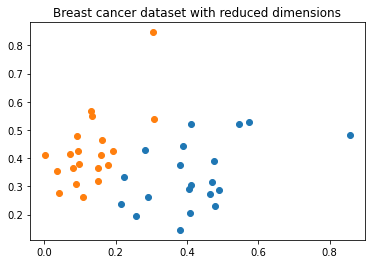

In [121]:
dim = 4
training_dataset_size = 20
testing_dataset_size = 10

class_labels = ["A", "B"]
sample_train, sample_test, label_train, label_test = train_test_split(data, target, random_state=10)

# Standardizing the dataset -- gaussian with unit variance and 0 mean
std = StandardScaler()
std.fit(sample_train)
sample_train = std.transform(sample_train)
sample_test = std.transform(sample_test)

# Using PCA to reduce no. of dimensions to 2 to match number of qubits
pca = PCA(dim)
pca.fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Scaling data to range from -1 to 1
minmax = MinMaxScaler()
minmax = minmax.fit(sample_train)
sample_train = minmax.transform(sample_train)
sample_test = minmax.transform(sample_test)

# Setting dataset size to number of training_dataset_size
training_input = {key: (sample_train[label_train == k, :])[:training_dataset_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:testing_dataset_size] for k, key in enumerate(class_labels)}

# Plotting data
for k in range(0, 2):
    plt.scatter(sample_train[label_train == k, 0][:training_dataset_size],
                sample_train[label_train == k, 1][:training_dataset_size])

plt.title("Breast cancer dataset with reduced dimensions")
plt.show()

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

### ZZFeatureMap ansatz

In [122]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     ├───┤├──────────────┤                                           └───┘»
q_3: ┤ H ├┤ U1(2.0*x[3]) ├────────────────────────────────────────────────»
     └───┘└──────────────┘                                                »
«                                                     »
«q_0: ───────────────────────────────────■─────────■──»
«                                        │         │  »
«q_1: ───────────────────────────────────┼────■────┼──»
«     ┌───────────────────────────────┐┌─┴─┐┌─┴─┐  │  »
«q_2: ┤ U1(2.0*(π - x[0])*(π - x[2])

In [123]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


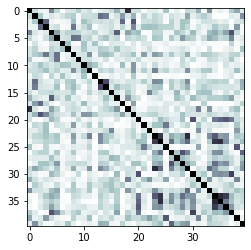

In [124]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [125]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print(" RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 RESULTS Testing success ratio:  0.95


### ZFeatureMap ansatz

In [126]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_3: ┤ H ├┤ U1(2.0*x[3]) ├┤ H ├┤ U1(2.0*x[3]) ├
     └───┘└──────────────┘└───┘└──────────────┘


In [127]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


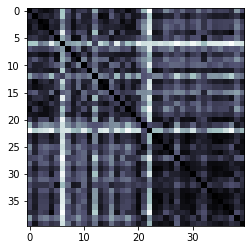

In [128]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [129]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
RESULTS Testing success ratio:  0.9


### PauliFeatureMap ansatz

In [130]:
backend = Aer.get_backend('qasm_simulator')
feature_map = PauliFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     ├───┤├──────────────┤                                           └───┘»
q_3: ┤ H ├┤ U1(2.0*x[3]) ├────────────────────────────────────────────────»
     └───┘└──────────────┘                                                »
«                                                     »
«q_0: ───────────────────────────────────■─────────■──»
«                                        │         │  »
«q_1: ───────────────────────────────────┼────■────┼──»
«     ┌───────────────────────────────┐┌─┴─┐┌─┴─┐  │  »
«q_2: ┤ U1(2.0*(π - x[0])*(π - x[2])

In [131]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


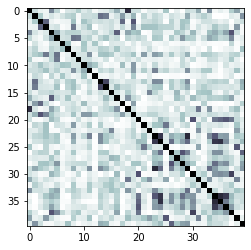

In [132]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [133]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
RESULTS Testing success ratio:  0.95


## 5 Dim

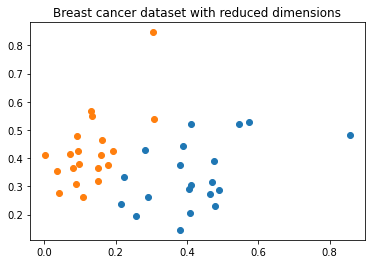

In [138]:
dim = 5
training_dataset_size = 20
testing_dataset_size = 10

class_labels = ["A", "B"]
sample_train, sample_test, label_train, label_test = train_test_split(data, target, random_state=10)

# Standardizing the dataset -- gaussian with unit variance and 0 mean
std = StandardScaler()
std.fit(sample_train)
sample_train = std.transform(sample_train)
sample_test = std.transform(sample_test)

# Using PCA to reduce no. of dimensions to 2 to match number of qubits
pca = PCA(dim)
pca.fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Scaling data to range from -1 to 1
minmax = MinMaxScaler()
minmax = minmax.fit(sample_train)
sample_train = minmax.transform(sample_train)
sample_test = minmax.transform(sample_test)

# Setting dataset size to number of training_dataset_size
training_input = {key: (sample_train[label_train == k, :])[:training_dataset_size] for k, key in enumerate(class_labels)}
test_input = {key: (sample_test[label_test == k, :])[:testing_dataset_size] for k, key in enumerate(class_labels)}

# Plotting data
for k in range(0, 2):
    plt.scatter(sample_train[label_train == k, 0][:training_dataset_size],
                sample_train[label_train == k, 1][:training_dataset_size])

plt.title("Breast cancer dataset with reduced dimensions")
plt.show()

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

### ZZFeatureMap ansatz

In [139]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     ├───┤├──────────────┤                                           └───┘»
q_3: ┤ H ├┤ U1(2.0*x[3]) ├────────────────────────────────────────────────»
     ├───┤├──────────────┤                                                »
q_4: ┤ H ├┤ U1(2.0*x[4]) ├────────────────────────────────────────────────»
     └───┘└──────────────┘                                                »
«                                                     »
«q_0: ───────────────────────────────────■─────────■──»
«                                        │         │

In [140]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


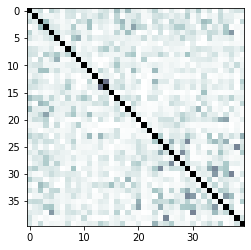

In [141]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [142]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print(" RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 RESULTS Testing success ratio:  0.95


### ZFeatureMap ansatz

In [143]:
backend = Aer.get_backend('qasm_simulator')
feature_map = ZFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_3: ┤ H ├┤ U1(2.0*x[3]) ├┤ H ├┤ U1(2.0*x[3]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_4: ┤ H ├┤ U1(2.0*x[4]) ├┤ H ├┤ U1(2.0*x[4]) ├
     └───┘└──────────────┘└───┘└──────────────┘


In [144]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


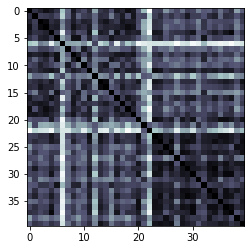

In [145]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [146]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
RESULTS Testing success ratio:  0.9


### PauliFeatureMap ansatz

In [151]:
backend = Aer.get_backend('qasm_simulator')
feature_map = PauliFeatureMap(dim, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐                                                »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■────■──»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├──────────────┤└───┘└───────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
     ├───┤├──────────────┤                                           └───┘»
q_3: ┤ H ├┤ U1(2.0*x[3]) ├────────────────────────────────────────────────»
     ├───┤├──────────────┤                                                »
q_4: ┤ H ├┤ U1(2.0*x[4]) ├────────────────────────────────────────────────»
     └───┘└──────────────┘                                                »
«                                                     »
«q_0: ───────────────────────────────────■─────────■──»
«                                        │         │

In [152]:
svm = QSVM(feature_map, training_input, test_input, None)
quantum_instance = QuantumInstance(backend, shots=10000)
result = svm.run(quantum_instance)

Kernel matrix during training


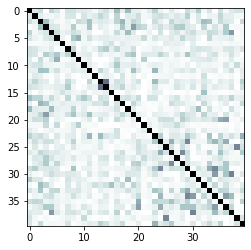

In [153]:
print("Kernel matrix during training")
kernel_mat = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_mat), origin='upper', interpolation='nearest', cmap='bone_r')
plt.show()

In [154]:
predicted_labels = svm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, svm.label_to_class)
print(f"Ground truth: {datapoints[1]}")
print(f"Prediction: {predicted_labels}")
print("RESULTS Testing success ratio: ", result['testing_accuracy'])

Ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
Prediction: [1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
RESULTS Testing success ratio:  0.95


## Results

![](images/QSVM%20breast%20cancer%20data%20set%20diff%20outcomes.jpg)